In [281]:
from __future__ import print_function
from __future__ import division

# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/image/cifar10/cifar10_input.py

In [282]:
%matplotlib inline

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

# Dataset

In [283]:
import cPickle
from mpl_toolkits.axes_grid.axes_grid import ImageGrid

In [284]:
def unpickle(path):
    with open(path, 'rb') as f:
        return cPickle.load(f)

In [285]:
data_batch_1 = unpickle("datasets/cifar10/data_batch_1")

In [286]:
images = np.swapaxes(data_batch_1['data'].reshape([-1, 32, 32, 3], order='F'), 1, 2)
labels = data_batch_1['labels']

In [287]:
def plot_images(images):
    fig = plt.figure(1, (3, 3))
    grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.1, aspect=True)

    for i in range(9):
        grid[i].imshow(images[i])
        grid[i].grid(False)

# Images

In [288]:
sess = tf.Session()

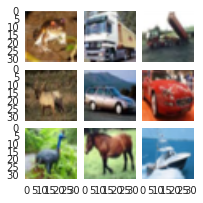

In [438]:
I = tf.constant(images[:10] / 255, tf.float32)
plot_images(sess.run(I))

## Downsample / Upsample

In [380]:
def downsample(I): # 1/2 I
    shape = I.get_shape() # [batch, height, width, channels]
    h = shape[1]
    w = shape[2]
    h2 = int(h // 2)
    w2 = int(w // 2)
    return tf.image.resize_images(I, h2, w2, tf.image.ResizeMethod.BILINEAR)

def upsample(I): # 2 I
    shape = I.get_shape() # [batch, height, width, channels]
    h = shape[1]
    w = shape[2]
    h2 = int(h * 2)
    w2 = int(w * 2)
    return tf.image.resize_images(I, h2, w2, tf.image.ResizeMethod.BILINEAR)

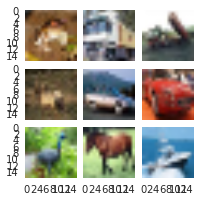

In [382]:
d = downsample(I)
plot_images(sess.run(d))

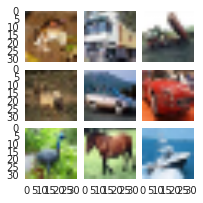

In [383]:
u = upsample(d)
plot_images(sess.run(u))

## Gaussian Pyramid

In [384]:
def gaussian_pyramid(I, K): # return I_0..I_k
    # downsample K times, final level K is small
    G = [I]
    for k in range(1, K):
        G_k = downsample(G[k - 1])
        G.append(G_k)
    return G

In [385]:
K = 3
G = gaussian_pyramid(I, 3)
G

[<tf.Tensor 'Const_20:0' shape=(10, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'ResizeBilinear_90:0' shape=(10, 16, 16, 3) dtype=float32>,
 <tf.Tensor 'ResizeBilinear_91:0' shape=(10, 8, 8, 3) dtype=float32>]

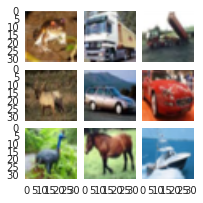

In [489]:
plot_images(sess.run(G[0]))

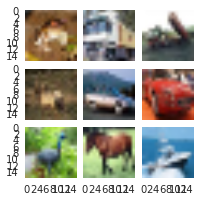

In [490]:
plot_images(sess.run(G[1]))

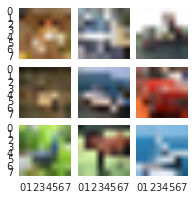

In [491]:
plot_images(sess.run(G[2]))

## Laplacian Pyramid

In [386]:
def laplacian_pyramid(G, K):
    L = []
    for k in range(K - 1):
        L_k = G[k] - upsample(G[k + 1])
        L.append(L_k)
    L.append(G[-1])
    return L

In [387]:
L = laplacian_pyramid(G, K)
L

[<tf.Tensor 'sub_41:0' shape=(10, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'sub_42:0' shape=(10, 16, 16, 3) dtype=float32>,
 <tf.Tensor 'ResizeBilinear_91:0' shape=(10, 8, 8, 3) dtype=float32>]

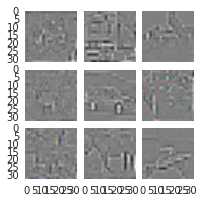

In [388]:
plot_images(sess.run(L[0] + 0.5))

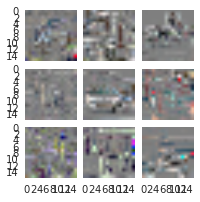

In [391]:
plot_images(sess.run(L[1]) + 0.5)

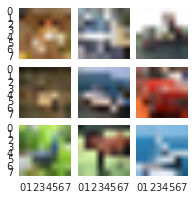

In [392]:
plot_images(sess.run(L[2]))

## Reconstruction

In [484]:
def reconstruct(h, K):
    I_K = h[K - 1]
    R = [I_K]
    for k in reversed(range(K - 1)):
        I_k = upsample(R[0]) + h[k]
        R.insert(0, I_k)
    return R

In [485]:
R = reconstruct(L, K)
R

[<tf.Tensor 'add_35:0' shape=(10, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'add_34:0' shape=(10, 16, 16, 3) dtype=float32>,
 <tf.Tensor 'ResizeBilinear_91:0' shape=(10, 8, 8, 3) dtype=float32>]

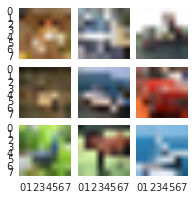

In [486]:
plot_images(sess.run(R[2]))

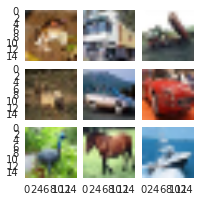

In [487]:
plot_images(sess.run(R[1]))

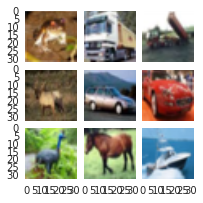

In [488]:
plot_images(sess.run(R[0]))